In [1]:
import argparse
import os
import sys
import warnings
import cv2


from matplotlib import pyplot as plt

from tensorflow.python import keras
from tensorflow.python.keras.preprocessing import image
import tensorflow as tf

import numpy as np

# Change these to absolute imports if you copy this script outside the keras_retinanet package.
from keras_retinanet import layers  # noqa: F401
from keras_retinanet import losses
from keras_retinanet import models
from keras_retinanet.callbacks import RedirectModel
from keras_retinanet.callbacks.eval import Evaluate
from keras_retinanet.models.retinanet import retinanet_bbox
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
from keras_retinanet.preprocessing.sail_generator import SAIL_Generator
from keras_retinanet.preprocessing.sail_val_generator import SAIL_val_Generator
from keras_retinanet.preprocessing.kitti import KittiGenerator
from keras_retinanet.preprocessing.open_images import OpenImagesGenerator
from keras_retinanet.preprocessing.pascal_voc import PascalVocGenerator
from keras_retinanet.utils.anchors import make_shapes_callback
from keras_retinanet.utils.config import read_config_file, parse_anchor_parameters
from keras_retinanet.utils.keras_version import check_keras_version
from keras_retinanet.utils.model import freeze as freeze_model
from keras_retinanet.utils.transform import random_transform_generator
from keras_retinanet.utils.sail_eval_data_generator import SAIL_EvalDataGenerator
from keras_retinanet.utils.anchors import anchors_for_shape, compute_gt_annotations
from keras_retinanet.utils.visualization import draw_boxes, draw_annotations
from keras_retinanet.utils.eval import _get_annotations, _get_detections

In [19]:
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 300

In [2]:
from argparse import Namespace

In [3]:
def create_test_generator(args):
    common_args = {
        'batch_size'       : args.batch_size,
        'config'           : args.config,
        'image_min_side'   : args.image_min_side,
        'image_max_side'   : args.image_max_side,
    }

    if args.annotations:
        if 'val_steps' in dir(args):
            validation_generator = SAIL_val_Generator(args.val_annotations,
                                                      args.classes,
                                                      transform_generator=None,
                                                      val_steps=args.val_steps,
                                                      **common_args)
        else:
            validation_generator = SAIL_val_Generator(args.val_annotations,
                                                      args.classes,
                                                      transform_generator=None,
                                                      **common_args)
    return validation_generator

In [72]:
args = Namespace(image_min_side=1024,
                 val_batch_size=16,
                 backbone='resnet152',
#                  val_steps=3,
                 weights='/app/Ant_mcs_detection/detection_retinanet/snapshots/resnet152_003a/resnet152_sail_12.h5',
                 annotations = '/app/Ant_mcs_detection/train_data_001/test/labels_all.pkl',
                 classes = '/app/Ant_mcs_detection/train_data_001/retinanet_classes.csv',
                 val_annotations='/app/Ant_mcs_detection/train_data_001/test/labels_all.pkl',
                 imagenet_weights = True, batch_size=16, epochs=10, steps=1024,
                 config = None, image_max_side = 1333)

In [5]:
with tf.device('/device:GPU:3'):
    config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False, device_count={'CPU': 1, 'GPU': 1})
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    keras.backend.set_session(session)

In [73]:
test_generator = create_test_generator(args)

reading annotatiuons file...
annotatiuons file read in 0.406323s...


In [7]:
model = models.load_model(os.path.abspath(args.weights), backbone_name=args.backbone)
model = models.convert_model(model)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
iou_threshold = 0.5
score_threshold = 0.05
max_detections = 100
save_path = None
weighted_average = False
verbose = True
eval_batch_size = 16

In [74]:
all_detections = _get_detections(test_generator, model,
                                 score_threshold=score_threshold,
                                 max_detections=max_detections,
                                 save_path=save_path,
                                 eval_batch_size=eval_batch_size)

624/624 [==============================] - 629s 1s/step


In [75]:
len(all_detections)

9984

In [76]:
all_annotations = _get_annotations(test_generator, predicted_items_count=len(all_detections))

Parsing annotations: 100% (9984 of 9984) || Elapsed Time: 0:00:00 Time:  0:00:00


In [77]:
len(all_annotations)

9984

In [222]:
example_idx = np.random.randint(len(all_detections))
example_idx

7909

In [223]:
image = np.asarray(test_generator.load_image(example_idx))

In [224]:
annotations = test_generator.load_annotations(example_idx)

In [225]:
annotations

{'bboxes': array([[144., 325., 273., 454.],
        [ 15.,  84., 144., 213.],
        [135., 406., 288., 559.]]), 'labels': array([0, 0, 0])}

In [226]:
curr_detections = all_detections[example_idx][0]

In [227]:
curr_detections.shape

(100, 5)

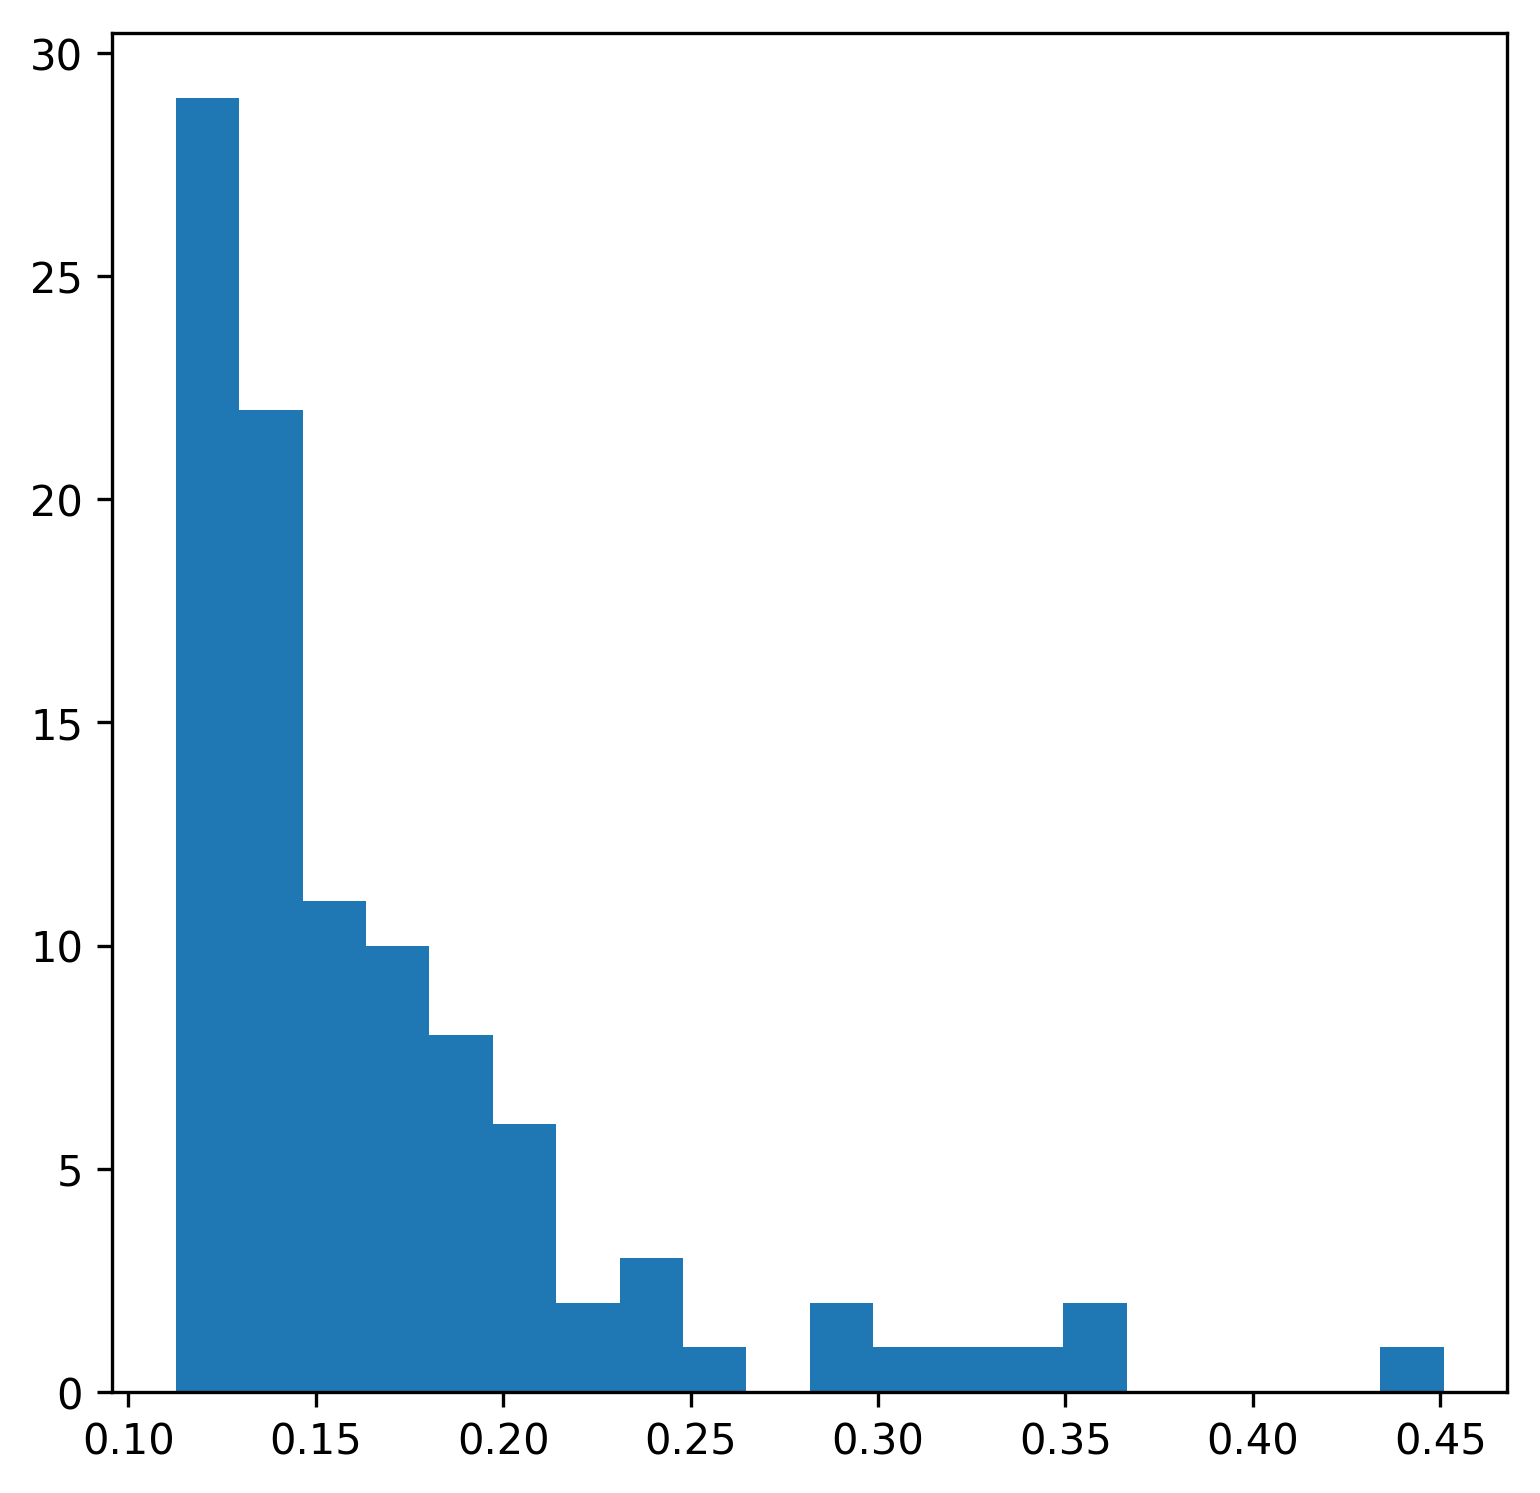

In [228]:
_ = plt.hist(curr_detections[:,-1], bins=20)

In [229]:
proba_thres = 0.35

In [230]:
(curr_detections[:,-1] >= proba_thres).sum()

3

In [231]:
selected_detections = curr_detections[curr_detections[:,-1]>=proba_thres,:]

In [232]:
selected_detections.shape

(3, 5)

In [233]:
bboxes = selected_detections[:,:4]
probas = selected_detections[:,-1]

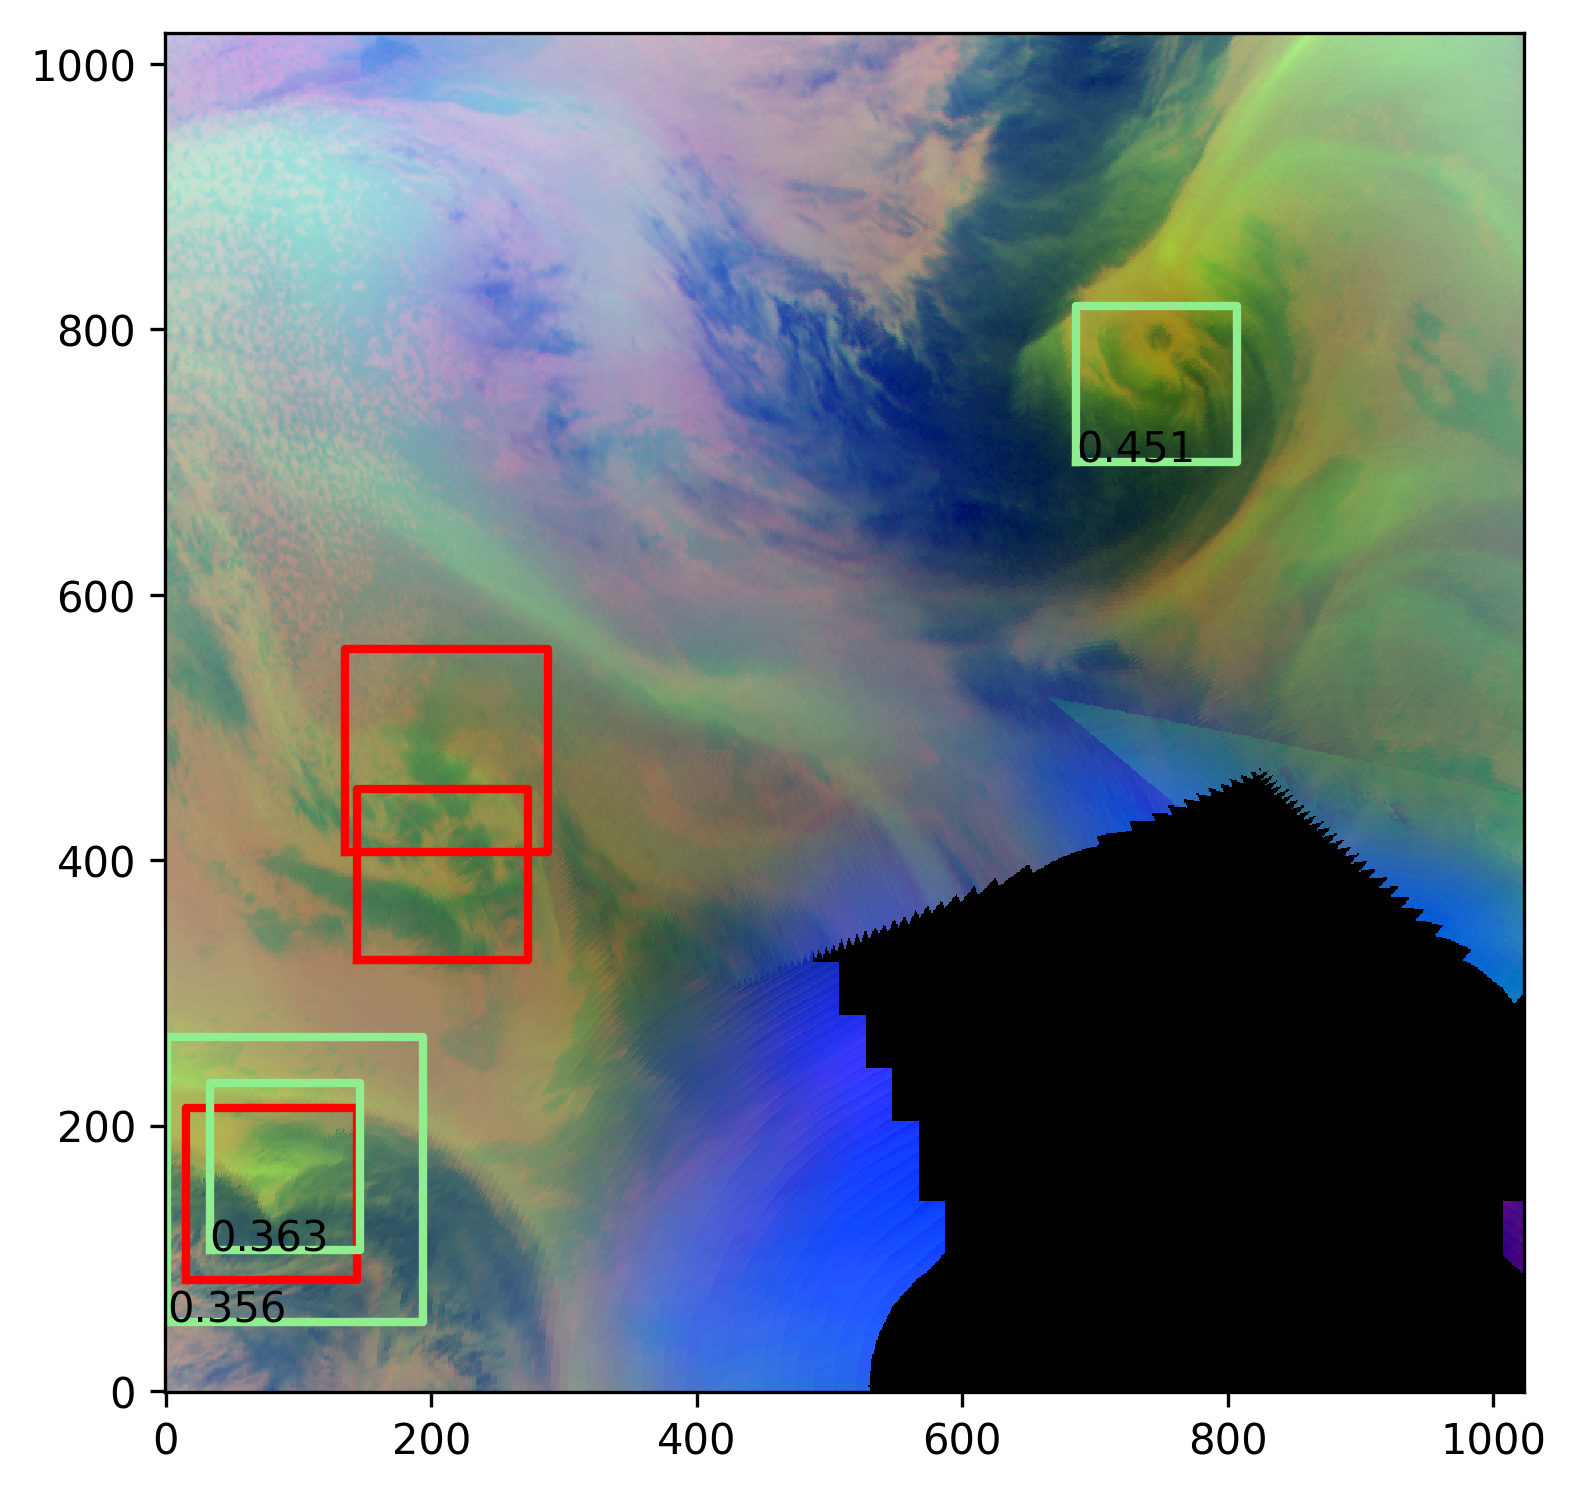

In [234]:
# plt.imshow(image[:,:,0], cmap='gray')
plt.imshow(image)
for i in range(annotations['bboxes'].shape[0]):
    label   = annotations['labels'][i]
    box = annotations['bboxes'][i]
    x1,y1,x2,y2 = np.array(box).astype(int)
    plt.plot([x1,x1,x2,x2,x1], [y1,y2,y2,y1,y1], color='red', linewidth=2)

for bbox,proba in zip(bboxes, probas):
    x1,y1,x2,y2 = bbox.astype(int)
    plt.plot([x1,x1,x2,x2,x1], [y1,y2,y2,y1,y1], color='lightgreen', linewidth=2)
    plt.text(x1, y1, '%.3f' % proba)